In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt
import scipy.io as sio
from mpl_toolkits.basemap import Basemap, cm

from netCDF4 import Dataset

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [6]:
# import cruise data

in_file = '../data/KuroAlldata.csv'
data = pd.read_csv(in_file, sep = ',')

in_file = '../data/Kuroshio_Phytoplankton.csv'
phyto = pd.read_csv(in_file, sep = ',')

in_file = '../data/Kuro_chl_coords.csv'
chl = pd.read_csv(in_file, sep = ',')

print chl.columns

Index([u'station', u'lat', u'lon', u'bottle', u'depth (m)', u'fluorescence',
       u'chlorophyll (ug/l)', u'Unnamed: 7'],
      dtype='object')


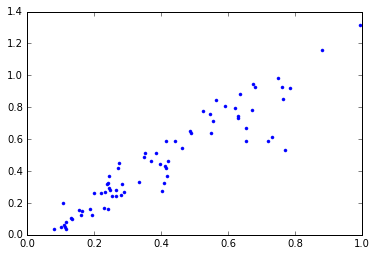

In [8]:
# do chl calibration

plt.plot(chl['fluorescence'], chl['chlorophyll (ug/l)'], '.')

In [ ]:
# try kmeans clustering on the data